<a href="https://colab.research.google.com/github/SeojinSeojin/deep-learning_challenge/blob/main/Classify_Nonlinear_Spiral_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Generate and Visualize Spiral Dataset

Source : https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/dataset/spiral.py

In [1]:
import numpy as np


def load_spiral_data(seed=1984):
    np.random.seed(seed)
    N = 100  # 클래스당 샘플 수
    DIM = 2  # 데어터 요소 수
    CLS_NUM = 3  # 클래스 수

    x = np.zeros((N*CLS_NUM, DIM))
    t = np.zeros((N*CLS_NUM, CLS_NUM), dtype=np.int)

    for j in range(CLS_NUM):
        for i in range(N): # N*j, N*(j+1)):
            rate = i / N
            radius = 1.0*rate
            theta = j*4.0 + 4.0*rate + np.random.randn()*0.2

            ix = N*j + i
            x[ix] = np.array([radius*np.sin(theta),
                              radius*np.cos(theta)]).flatten()
            t[ix, j] = 1

    return x, t

In [2]:
x, t = load_spiral_data()

print('x', x.shape)
print('t', t.shape)

x (300, 2)
t (300, 3)


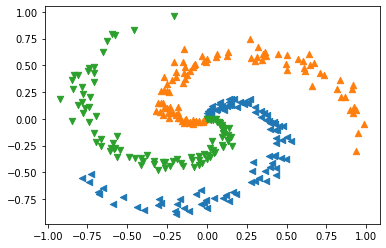

In [3]:
import matplotlib.pyplot as plt 

N = 100
CLS_NUM = 3
markers = ['<', '^', 'v']
for i in range(CLS_NUM):
    plt.scatter(x[i*N:(i+1)*N, 0], x[i*N:(i+1)*N, 1], s=40, marker=markers[i])
plt.show()

## Define Layers

source : https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/common/layers.py

In [4]:
def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 정답 데이터가 원핫 벡터일 경우 정답 레이블 인덱스로 변환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        W, b = self.params
        out = np.dot(x, W) + b
        self.x = x
        return out

    def backward(self, dout):
        W, b = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        db = np.sum(dout, axis=0)

        self.grads[0][...] = dW
        self.grads[1][...] = db
        return dx

class Sigmoid:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmax의 출력
        self.t = None  # 정답 레이블

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 정답 레이블이 원핫 벡터일 경우 정답의 인덱스로 변환
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx

## Define Optimizer

Source : https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/common/optimizer.py

In [5]:
class SGD:
    '''
    확률적 경사하강법(Stochastic Gradient Descent)
    '''
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr * grads[i]

## Define Neural Network

source : https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/ch01/two_layer_net.py

In [6]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size):
        # 입력층 뉴런 수, 은닉층 뉴런 수, 출력층 뉴런 수 입력
        I, H, O = input_size, hidden_size, output_size

        # Initialize weights
        W1 = 0.01 * np.random.randn(I, H)
        b1 = np.zeros(H)
        W2 = 0.01 * np.random.randn(H, O)
        b2 = np.zeros(O)

        # Set layers
        # affine -> sigmoid -> affine -> softmaxwithloss
        self.layers = [
            Affine(W1, b1),
            Sigmoid(),
            Affine(W2, b2)
        ]
        self.loss_layer = SoftmaxWithLoss()

        # Save layers' gradients and parameters
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, x): # 추론
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def forward(self, x, t): # 순전파
        score = self.predict(x)
        loss = self.loss_layer.forward(score, t)
        return loss

    def backward(self, dout=1): # 역전파
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

## Train Dataset

source : https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/ch01/train_custom_loop.py

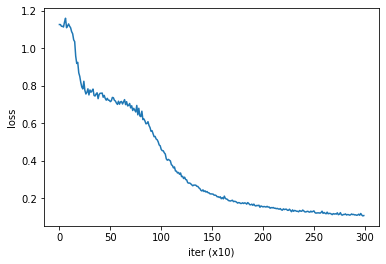

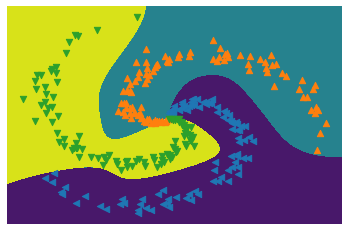

In [7]:
max_epoch = 300
batch_size = 30
hidden_size = 10
learning_rate = 1.0

model = TwoLayerNet(input_size=2, hidden_size=hidden_size, output_size=3)
optimizer = SGD(lr=learning_rate)

data_size = len(x)
max_iters = data_size // batch_size
total_loss = 0
loss_count = 0
loss_list = []

for epoch in range(max_epoch):
    idx = np.random.permutation(data_size)
    x = x[idx]
    t = t[idx]

    for iters in range(max_iters):
        batch_x = x[iters*batch_size:(iters+1)*batch_size]
        batch_t = t[iters*batch_size:(iters+1)*batch_size]

        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)

        total_loss += loss
        loss_count += 1

        if (iters+1) % 10 == 0:
            avg_loss = total_loss / loss_count
            if (iters+1) % 100 == 0:
              print('| epoch %d |  iter %d / %d | loss %.2f'
                  % (epoch + 1, iters + 1, max_iters, avg_loss))
            loss_list.append(avg_loss)
            total_loss, loss_count = 0, 0

plt.plot(np.arange(len(loss_list)), loss_list, label='train')
plt.xlabel('iter (x10)')
plt.ylabel('loss')
plt.show()

# 여기부터 처음 보는 내용!!

h = 0.001

# (1) 여기부터 색칠!!
# 좌표 만들기
x_min, x_max = x[:, 0].min() - .1, x[:, 0].max() + .1
y_min, y_max = x[:, 1].min() - .1, x[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# meshgrid로 얻은 x,y 좌표들을 1차원으로 바꿔주고 붙여준다.
X = np.c_[xx.ravel(), yy.ravel()]
# 각 좌표에 대해 predict 진행
score = model.predict(X)
predict_cls = np.argmax(score, axis=1)
Z = predict_cls.reshape(xx.shape)
# 좌표 색칠하기
plt.contourf(xx, yy, Z)
plt.axis('off')

# (2) 여기부터 처음에 그렸던거 그리기
x, t = load_spiral_data()
N = 100
CLS_NUM = 3
markers = ['<', '^', 'v']
for i in range(CLS_NUM):
    plt.scatter(x[i*N:(i+1)*N, 0], x[i*N:(i+1)*N, 1], s=40, marker=markers[i])
plt.show()

## 처음 보는 함수 조사

### **numpy.meshgrid** : 격자(grid)를 만들어주는 친구
docs : https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html

N개의 1차원 좌표 배열(xi)에서 N차원 직사각형 격자를 만드는 함수

``` python
def numpy.meshgrid(좌표 배열):
  ...
  return ndarray of coordinate matrices
```

<p>그림을 쉽게 그리기 위해 <b>'좌표'</b>를 리턴한다.</p>
아래 예제를 보면, x좌표 값들과 y좌표 값들을 파라미터로 넘겨주면 해당 값들을 복제한 xx와 yy를 리턴한다. 이 값들을 조합하면 범위 속의 모든 좌표를 순서대로 얻을 수 있다. 

In [8]:
import numpy as np

x=np.linspace(1,10,5)
y=np.linspace(6,10,2)
print("input : ", x, y)

xx,yy=np.meshgrid(x,y)

print("xx matrix:")
print(xx)
print("shape of xx matrix:", xx.shape)

print("yy matrix:")
print(yy)
print("shape of yy matrix:", yy.shape)

input :  [ 1.    3.25  5.5   7.75 10.  ] [ 6. 10.]
xx matrix:
[[ 1.    3.25  5.5   7.75 10.  ]
 [ 1.    3.25  5.5   7.75 10.  ]]
shape of xx matrix: (2, 5)
yy matrix:
[[ 6.  6.  6.  6.  6.]
 [10. 10. 10. 10. 10.]]
shape of yy matrix: (2, 5)


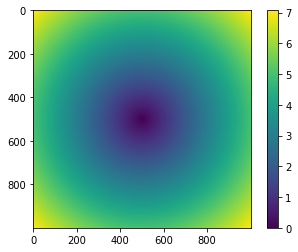

In [9]:
points = np.arange(-5,5,0.01)
xs, ys = np.meshgrid(points, points)
z = np.sqrt(xs**2 + ys**2)

plt.imshow(z, cmap=plt.cm.viridis); plt.colorbar()

### **matplotlib.pyplot.scatter** : 산점도(scappter plot)를 그려주는 친구
docs : https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html

``` python
def matplotlib.pyplot.scatter(x,y좌표 모음) :
  draw scatter plot
```
<p>각 점들의 좌표평면 상에서의 <b>분포</b>를 보여주는 그래프를 그린다.</p>

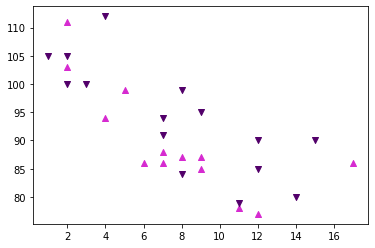

In [16]:
x = np.array([5,7,8,7,2,17,2,9,4,11,12,9,6])
y = np.array([99,86,87,88,111,86,103,87,94,78,77,85,86])
plt.scatter(x, y, color="#D62AD0", marker="^")

x = np.array([2,2,8,1,15,8,12,9,7,3,11,4,7,14,12])
y = np.array([100,105,84,105,90,99,90,95,94,100,79,112,91,80,85])
plt.scatter(x, y, color="#52006A", marker="v")

plt.show()

### **matplotlib.pyplot.contourf** : 등차선(contour)을 표현해주는 친구
docs : https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contourf.html


``` python
def matplotlib.pyplot.contourf(x,y좌표, Z, contour line의 수, ..):
  draw QuadContourSet
```
<p>그림 그려주는 친구</p>
<p>머신러닝에서는 우리 모델이 <b>어느 좌표를 어느 클래스로 인식하는지</b> 구별하는 데에 사용한다.</p>
x,y좌표는 필수는 아님! 중요한건 z값에 담겨있는 각 좌표의 값들이다

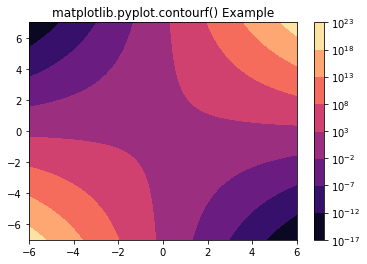

In [13]:
from numpy import ma
from matplotlib import ticker, cm
   
N = 2000
x = np.linspace(-6.0, 6.0, N)
y = np.linspace(-7.0, 7.0, N)
X, Y = np.meshgrid(x, y)
   
Z1 = np.exp(X * Y)
z = 100 * Z1
z[:5, :5] = -1
z = ma.masked_where(z <= 0, z)
   
cs = plt.contourf(X, Y, z,
                  locator = ticker.LogLocator(),
                  cmap ="magma")
  
cbar = plt.colorbar(cs)
  
plt.title('matplotlib.pyplot.contourf() Example')
plt.show()